修改rainfall_runoff_event_identify中的参数

In [1]:
import numpy as np
import pandas as pd

def movmean(X, n):
    ones = np.ones(X.shape)
    kernel = np.ones(n)
    return np.convolve(X, kernel, mode="same") / np.convolve(ones, kernel, mode="same")


def step1_step2_tr_and_fluctuations_timeseries(rain, flow, rain_min, max_window):
    """
    The first two steps are used for calculation of the catchment response time,
    the rainfall and streamflow fluctuations, and rainfall fluctuation.

    Parameters
    ----------
    rain : np.ndarray
        unit is mm/h
    flow : np.ndarray
        unit is m³/h
    rain_min : _type_
        最小降雨量阈值
    max_window : _type_
        场次划分最大窗口, 决定场次长度

    Returns
    -------
    _type_
        _description_
    """
    rain = rain.T
    flow = flow.T
    rain_int = np.nancumsum(rain)
    flow_int = np.nancumsum(flow)
    T = rain.size
    rain_mean = np.empty(((max_window - 1) // 2, T))
    flow_mean = np.empty(((max_window - 1) // 2, T))
    fluct_rain = np.empty(((max_window - 1) // 2, T))
    fluct_flow = np.empty(((max_window - 1) // 2, T))
    F_rain = np.empty((max_window - 1) // 2)
    F_flow = np.empty((max_window - 1) // 2)
    F_rain_flow = np.empty((max_window - 1) // 2)
    rho = np.empty((max_window - 1) // 2)
    for window in np.arange(3, max_window + 1, 2):
        int_index = int((window - 1) / 2 - 1)
        start_slice = int(window - 0.5 * (window - 1))
        dst_slice = int(T - 0.5 * (window - 1))
        # 新建一个循环体长度*数据长度的大数组
        rain_mean[int_index] = movmean(rain_int, window)
        flow_mean[int_index] = movmean(flow_int, window)
        fluct_rain[int_index] = rain_int - rain_mean[int_index, :]
        F_rain[int_index] = (1 / (T - window + 1)) * np.nansum(
            (fluct_rain[int_index, start_slice:dst_slice]) ** 2
        )
        fluct_flow[int_index, np.newaxis] = flow_int - flow_mean[int_index, :]
        F_flow[int_index] = (1 / (T - window + 1)) * np.nansum(
            (fluct_flow[int_index, start_slice:dst_slice]) ** 2
        )
        F_rain_flow[int_index] = (1 / (T - window + 1)) * np.nansum(
            (fluct_rain[int_index, start_slice:dst_slice])
            * (fluct_flow[int_index, start_slice:dst_slice])
        )
        rho[int_index] = F_rain_flow[int_index] / (
            np.sqrt(F_rain[int_index]) * np.sqrt(F_flow[int_index])
        )
    pos_min = np.argmin(rho)
    Tr = pos_min + 1
    tol_fluct_rain = (rain_min / (2 * Tr + 1)) * Tr
    tol_fluct_flow = flow_int[-1] / 1e15
    fluct_rain[pos_min, np.fabs(fluct_rain[pos_min, :]) < tol_fluct_rain] = 0
    fluct_flow[pos_min, np.fabs(fluct_flow[pos_min, :]) < tol_fluct_flow] = 0
    fluct_rain_Tr = fluct_rain[pos_min, :]
    fluct_flow_Tr = fluct_flow[pos_min, :]
    fluct_bivariate_Tr = fluct_rain_Tr * fluct_flow_Tr
    fluct_bivariate_Tr[np.fabs(fluct_bivariate_Tr) < np.finfo(np.float64).eps] = (
        0  # 便于比较
    )
    return Tr, fluct_rain_Tr, fluct_flow_Tr, fluct_bivariate_Tr


def step3_core_identification(fluct_bivariate_Tr):
    d = np.diff(
        fluct_bivariate_Tr, prepend=[0], append=[0]
    )  # 计算相邻数值差分，为0代表两端点处于0区间
    d[np.fabs(d) < np.finfo(np.float64).eps] = 0  # 确保计算正确
    d = np.logical_not(d)  # 求0-1数组，为真代表为0区间
    d0 = np.logical_not(
        np.convolve(d, [1, 1], "valid")
    )  # 对相邻元素做OR，代表原数组数值是否处于某一0区间，再取反表示取有效值
    valid = np.logical_or(fluct_bivariate_Tr, d0)  # 有效core
    d_ = np.diff(valid, prepend=[0], append=[0])  # 求差分方便取上下边沿
    beginning_core = np.argwhere(d_ == 1)  # 上边沿为begin
    end_core = np.argwhere(d_ == -1) - 1  # 下边沿为end
    return beginning_core, end_core


def step4_end_rain_events(beginning_core, end_core, rain, fluct_rain_Tr, rain_min):
    end_rain = end_core.copy()
    rain = rain.T
    for g in range(end_core.size):
        if end_core[g] + 2 < fluct_rain_Tr.size and (
            np.fabs(fluct_rain_Tr[end_core[g] + 1]) < np.finfo(np.float64).eps
            and np.fabs(fluct_rain_Tr[end_core[g] + 2]) < np.finfo(np.float64).eps
        ):
            # case 1&2
            if np.fabs(rain[end_core[g]]) < np.finfo(np.float64).eps:
                # case 1
                while (
                    end_rain[g] > beginning_core[g]
                    and np.fabs(rain[end_rain[g]]) < np.finfo(np.float64).eps
                ):
                    end_rain[g] = end_rain[g] - 1
            else:
                # case 2
                bound = (
                    beginning_core[g + 1] if g + 1 < beginning_core.size else rain.size
                )
                while end_rain[g] < bound and rain[end_rain[g]] > rain_min:
                    end_rain[g] = end_rain[g] + 1
                end_rain[g] = end_rain[g] - 1  # 回到最后一个
        else:
            # case 3
            # 若在降水，先跳过
            while end_rain[g] >= beginning_core[g] and rain[end_rain[g]] > rain_min:
                end_rain[g] = end_rain[g] - 1
            while end_rain[g] >= beginning_core[g] and rain[end_rain[g]] < rain_min:
                end_rain[g] = end_rain[g] - 1
    return end_rain


def step5_beginning_rain_events(
    beginning_core, end_rain, rain, fluct_rain_Tr, rain_min
):
    beginning_rain = beginning_core.copy()
    rain = rain.T
    for g in range(beginning_core.size):
        if (
            beginning_core[g] >= 2
            and np.fabs(fluct_rain_Tr[beginning_core[g] - 1]) < np.finfo(np.float64).eps
            and np.fabs(fluct_rain_Tr[beginning_core[g] - 2]) < np.finfo(np.float64).eps
            and np.fabs(rain[beginning_core[g]]) < np.finfo(np.float64).eps
        ):
            # case 1
            while (
                beginning_rain[g] < end_rain[g]
                and np.fabs(rain[beginning_rain[g]]) < np.finfo(np.float64).eps
            ):
                beginning_rain[g] = beginning_rain[g] + 1
        else:
            # case 2&3
            bound = end_rain[g - 1] if g >= 1 else -1
            while beginning_rain[g] > bound and rain[beginning_rain[g]] > rain_min:
                beginning_rain[g] = beginning_rain[g] - 1
            beginning_rain[g] = beginning_rain[g] + 1  # 回到第一个
    return beginning_rain


def step6_checks_on_rain_events(
    beginning_rain, end_rain, rain, rain_min, beginning_core, end_core
):
    rain = rain.T
    beginning_rain = beginning_rain.copy()
    end_rain = end_rain.copy()
    if beginning_rain[0] == 0:  # 掐头
        beginning_rain = beginning_rain[1:]
        end_rain = end_rain[1:]
        beginning_core = beginning_core[1:]
        end_core = end_core[1:]
    if end_rain[-1] == rain.size - 1:  # 去尾
        beginning_rain = beginning_rain[:-2]
        end_rain = end_rain[:-2]
        beginning_core = beginning_core[:-2]
        end_core = end_core[:-2]
    error_time_reversed = beginning_rain > end_rain
    error_wrong_delimiter = np.logical_or(
        rain[beginning_rain - 1] > rain_min, rain[end_rain + 1] > rain_min
    )
    beginning_rain[error_time_reversed] = -2
    beginning_rain[error_wrong_delimiter] = -2
    end_rain[error_time_reversed] = -2
    end_rain[error_wrong_delimiter] = -2
    beginning_core[error_time_reversed] = -2
    beginning_core[error_wrong_delimiter] = -2
    end_core[error_time_reversed] = -2
    end_core[error_wrong_delimiter] = -2
    beginning_rain = beginning_rain[beginning_rain != -2]
    end_rain = end_rain[end_rain != -2]
    beginning_core = beginning_core[beginning_core != -2]
    end_core = end_core[end_core != -2]
    return beginning_rain, end_rain, beginning_core, end_core


def step7_end_flow_events(
    end_rain_checked, beginning_core, end_core, rain, fluct_rain_Tr, fluct_flow_Tr, Tr
):
    end_flow = np.empty(end_core.size, dtype=int)
    for g in range(end_rain_checked.size):
        if end_core[g] + 2 < fluct_rain_Tr.size and (
            np.fabs(fluct_rain_Tr[end_core[g] + 1]) < np.finfo(np.float64).eps
            and np.fabs(fluct_rain_Tr[end_core[g] + 2]) < np.finfo(np.float64).eps
        ):
            # case 1
            end_flow[g] = end_rain_checked[g]
            bound = (
                beginning_core[g + 1] + Tr if g + 1 < beginning_core.size else rain.size
            )
            bound = min(bound, rain.size)  # 防溢出
            # 若flow为负，先跳过
            while end_flow[g] < bound and fluct_flow_Tr[end_flow[g]] <= 0:
                end_flow[g] = end_flow[g] + 1
            while end_flow[g] < bound and fluct_flow_Tr[end_flow[g]] > 0:
                end_flow[g] = end_flow[g] + 1
            end_flow[g] = end_flow[g] - 1  # 回到最后一个
        else:
            # case 2
            end_flow[g] = end_core[g]
            while end_flow[g] >= beginning_core[g] and fluct_flow_Tr[end_flow[g]] <= 0:
                end_flow[g] = end_flow[g] - 1
    return end_flow


def step8_beginning_flow_events(
    beginning_rain_checked,
    end_rain_checked,
    rain,
    beginning_core,
    fluct_rain_Tr,
    fluct_flow_Tr,
):
    beginning_flow = np.empty(beginning_rain_checked.size, dtype=int)
    for g in range(beginning_rain_checked.size):
        if beginning_core[g] >= 2 and (
            np.fabs(fluct_rain_Tr[beginning_core[g] - 1]) < np.finfo(np.float64).eps
            and np.fabs(fluct_rain_Tr[beginning_core[g] - 2]) < np.finfo(np.float64).eps
        ):
            beginning_flow[g] = beginning_rain_checked[g]  # case 1
        else:
            beginning_flow[g] = beginning_core[g]  # case 2
        while (
            beginning_flow[g] < end_rain_checked[g]
            and fluct_flow_Tr[beginning_flow[g]] >= 0
        ):
            beginning_flow[g] = beginning_flow[g] + 1
    return beginning_flow


def step9_checks_on_flow_events(
    beginning_rain_checked, end_rain_checked, beginning_flow, end_flow, fluct_flow_Tr
):
    beginning_flow_checked = np.empty_like(beginning_flow, dtype=object)
    end_flow_checked = np.empty_like(end_flow, dtype=object)
    for g in range(len(beginning_flow)):
        if (
            not np.isnan(beginning_flow[g])
            and not np.isnan(end_flow[g])
            and (
                end_flow[g] <= beginning_flow[g]
                or fluct_flow_Tr[beginning_flow[g]] > 0
                or fluct_flow_Tr[end_flow[g]] < 0
                or beginning_flow[g] < beginning_rain_checked[g]
                or end_flow[g] < end_rain_checked[g]
            )
        ):
            beginning_flow_checked[g] = np.nan
            end_flow_checked[g] = np.nan
        else:
            beginning_flow_checked[g] = beginning_flow[g]
            end_flow_checked[g] = end_flow[g]

    index_events = [
        i
        for i in range(len(beginning_rain_checked))
        if not np.isnan(beginning_rain_checked[i])
        and not np.isnan(beginning_flow_checked[i])
        and not np.isnan(end_rain_checked[i])
        and not np.isnan(end_flow_checked[i])
    ]

    beginning_flow_ungrouped = beginning_flow_checked[index_events]
    end_flow_ungrouped = end_flow_checked[index_events]
    beginning_rain_ungrouped = beginning_rain_checked[index_events]
    end_rain_ungrouped = end_rain_checked[index_events]
    return (
        beginning_rain_ungrouped,
        end_rain_ungrouped,
        beginning_flow_ungrouped,
        end_flow_ungrouped,
    )
    # The following code is written by Wang, Yang
    # error_time_reversed = beginning_flow > end_flow
    # error_wrong_fluct = np.logical_or(
    #     np.logical_or(fluct_flow_Tr[beginning_flow] > 0, fluct_flow_Tr[end_flow] < 0),
    #     np.logical_or(
    #         beginning_flow < beginning_rain_checked, end_flow < end_rain_checked
    #     ),
    # )
    # beginning_flow[error_time_reversed] = -3
    # beginning_flow[error_wrong_fluct] = -3
    # end_flow[error_time_reversed] = -3
    # end_flow[error_wrong_fluct] = -3
    # beginning_flow = beginning_flow[beginning_flow != -3]
    # end_flow = end_flow[end_flow != -3]

    # beginning_rain_checked[error_time_reversed] = -3
    # beginning_rain_checked[error_wrong_fluct] = -3
    # end_rain_checked[error_time_reversed] = -3
    # end_rain_checked[error_wrong_fluct] = -3
    # beginning_rain = beginning_rain_checked[beginning_rain_checked != -3]
    # end_rain = end_rain_checked[end_rain_checked != -3]
    # return beginning_rain, end_rain, beginning_flow, end_flow


def step10_checks_on_overlapping_events(
    beginning_rain_ungrouped,
    end_rain_ungrouped,
    beginning_flow_ungrouped,
    end_flow_ungrouped,
    time,
):
    # rain
    # order1 = np.reshape(
    #     np.hstack(
    #         (
    #             np.reshape(beginning_rain_ungrouped, (-1, 1)),
    #             np.reshape(end_rain_ungrouped, (-1, 1)),
    #         )
    #     ),
    #     (1, -1),
    # )
    # reversed1 = np.diff(order1) <= 0
    # order1[np.hstack((reversed1, [[False]]))] = -2
    # order1[np.hstack(([[False]], reversed1))] = -2
    # order1 = order1[order1 != -2]
    # # flow
    # order2 = np.reshape(
    #     np.hstack(
    #         (
    #             np.reshape(beginning_flow_ungrouped, (-1, 1)),
    #             np.reshape(end_flow_ungrouped, (-1, 1)),
    #         )
    #     ),
    #     (1, -1),
    # )
    # reversed2 = np.diff(order2) <= 0
    # order2[np.hstack((reversed2, [[False]]))] = -3
    # order2[np.hstack(([[False]], reversed2))] = -3
    # order2 = order2[order2 != -3]
    # # group
    # rain_grouped = np.reshape(order1, (-1, 2)).T
    # beginning_rain_grouped = rain_grouped[0]
    # end_rain_grouped = rain_grouped[1]
    # flow_grouped = np.reshape(order2, (-1, 2)).T
    # beginning_flow_grouped = flow_grouped[0]
    # end_flow_grouped = flow_grouped[1]
    # return (
    #     time[beginning_rain_grouped],
    #     time[end_rain_grouped],
    #     time[beginning_flow_grouped],
    #     time[end_flow_grouped],
    # )

    beginning_rain_ungrouped = beginning_rain_ungrouped.astype(float)
    beginning_flow_ungrouped = beginning_flow_ungrouped.astype(float)
    end_rain_ungrouped = end_rain_ungrouped.astype(float)
    end_flow_ungrouped = end_flow_ungrouped.astype(float)
    q = 1
    marker_overlapping = []
    for g in range(len(end_rain_ungrouped) - 1):
        if (
            end_rain_ungrouped[g] > beginning_rain_ungrouped[g + 1]
            or end_flow_ungrouped[g] > beginning_flow_ungrouped[g + 1]
        ):
            marker_overlapping.append(g)
            q += 1
    if marker_overlapping:
        q = 0
        while q < len(marker_overlapping) - 1:
            to_group = [marker_overlapping[q]]
            while (
                q < len(marker_overlapping)
                and marker_overlapping[q] == marker_overlapping[q + 1] - 1
            ):
                to_group.append(marker_overlapping[q + 1])
                q += 1

            beginning_rain_ungrouped[to_group[0]] = beginning_rain_ungrouped[
                to_group[0]
            ]
            beginning_flow_ungrouped[to_group[0]] = beginning_flow_ungrouped[
                to_group[0]
            ]
            end_flow_ungrouped[to_group[0]] = end_flow_ungrouped[to_group[-1] + 1]
            end_rain_ungrouped[to_group[0]] = end_rain_ungrouped[to_group[-1] + 1]

            if len(to_group) > 1:
                beginning_rain_ungrouped[to_group[1:]] = np.nan
                beginning_flow_ungrouped[to_group[1:]] = np.nan
                end_flow_ungrouped[to_group[1:]] = np.nan
                end_rain_ungrouped[to_group[1:]] = np.nan

            beginning_rain_ungrouped[to_group[-1] + 1] = np.nan
            beginning_flow_ungrouped[to_group[-1] + 1] = np.nan
            end_flow_ungrouped[to_group[-1] + 1] = np.nan
            end_rain_ungrouped[to_group[-1] + 1] = np.nan

            to_group = []
            q += 1

    index_events2 = np.where(
        ~np.isnan(beginning_rain_ungrouped)
        & ~np.isnan(beginning_flow_ungrouped)
        & ~np.isnan(end_rain_ungrouped)
        & ~np.isnan(end_flow_ungrouped)
    )[0]
    beginning_flow_grouped = beginning_flow_ungrouped[index_events2]
    end_flow_grouped = end_flow_ungrouped[index_events2]
    beginning_rain_grouped = beginning_rain_ungrouped[index_events2]
    end_rain_grouped = end_rain_ungrouped[index_events2]
    beginning_rain_grouped = beginning_rain_grouped.astype(int)
    end_rain_grouped = end_rain_grouped.astype(int)
    beginning_flow_grouped = beginning_flow_grouped.astype(int)
    end_flow_grouped = end_flow_grouped.astype(int)
    beginning_rain = time[beginning_rain_grouped]
    end_rain = time[end_rain_grouped]
    end_flow = time[end_flow_grouped]
    beginning_flow = time[beginning_flow_grouped]
    return beginning_rain, end_rain, beginning_flow, end_flow
    # biliu_rain_division = pd.DataFrame({'BEGINNING_RAIN': BEGINNING_RAIN, 'END_RAIN': END_RAIN})
    # biliu_rain_division.to_csv(os.path.join(definitions.ROOT_DIR, 'example/yingnariver_data/yingna_rain_flow_division/yingna_rain_division.txt'), sep='\t')
    # biliu_flow_division = pd.DataFrame({'BEGINNING_FLOW': BEGINNING_FLOW, 'END_FLOW': END_FLOW})
    # biliu_flow_division.to_csv(os.path.join(definitions.ROOT_DIR, 'example/yingnariver_data/yingna_rain_flow_division/yingna_flow_division.txt'), sep='\t')


def baseflow_curve(beginning_flow, end_flow, flow, time):
    baseflow = np.copy(flow)
    beg_end_series = np.array([], dtype=beginning_flow[0].dtype)
    for j in range(len(beginning_flow)):
        beg_end_series = np.concatenate(
            (beg_end_series, [beginning_flow[j], end_flow[j]])
        )

    for k in range(len(beg_end_series) - 1):
        index_beg = np.where(time == beg_end_series[k])[0]
        index_end = np.where(time == beg_end_series[k + 1])[0]
        index_beg = int(index_beg)
        index_end = int(index_end)
        if (
            len(np.where(np.isnan(flow[index_beg : index_end + 1]) == 1)[0])
            >= len(flow[index_beg : index_end + 1]) * 0.9
        ):
            baseflow[index_beg : index_end + 1] = np.nan
        elif index_end - index_beg == 1:
            baseflow[index_beg] = flow[index_beg]
            baseflow[index_end] = flow[index_end]
        elif flow[index_beg] < flow[index_end]:
            increment = (flow[index_end] - flow[index_beg]) / (index_end - index_beg)
            for m in range(index_beg + 1, index_end):
                baseflow[m] = baseflow[index_beg] + increment * (m - index_beg)
        elif flow[index_beg] > flow[index_end]:
            increment = (flow[index_beg] - flow[index_end]) / (index_end - index_beg)
            for m in range(index_beg + 1, index_end):
                baseflow[m] = baseflow[index_beg] - increment * (m - index_beg)

    for m in range(len(baseflow)):
        baseflow[m] = min(baseflow[m], flow[m])
    return baseflow


def step11_event_analysis(
    beginning_rain,
    end_rain,
    beginning_flow,
    end_flow,
    rain,
    flow,
    time,
    flow_threshold,
    multiple=1,
    flag=0,
    duration_max=2400,
):
    """The step 11 is a new step for the DMCA-ESR method
    we proposed to check again for the rainfall-runoff events.

    Parameters
    ----------
    beginning_rain : _type_
        _description_
    end_rain : _type_
        _description_
    beginning_flow : _type_
        _description_
    end_flow : _type_
        _description_
    rain : _type_
        _description_
    flow : _type_
        _description_
    time : _type_
        _description_
    flag : int, by default 0
        if flag != 1, calculation target is flow - baseflow,
        if flag == 1, cal target is flow
        the default value 0 is recommended as flag == 1 is just for comparison
    multiple : int
        1h means the multiple is 1, 1d means the multiple is 24
    flow_threshold : float
        flow threshold -- remove events with max flow lower than it
        its unit is mm_h
    duration_max : int
        maximum duration of the rainfall-runoff events we set; unit is hour

    Returns
    -------
    _type_
        _description_
    """
    duration_rain = np.zeros(len(beginning_rain))
    duration_runoff = np.zeros(len(beginning_flow))
    volume_rain = np.zeros(len(beginning_rain))
    volume_runoff = np.zeros(len(beginning_flow))
    runoff_ratio = np.zeros(len(beginning_rain))
    for h in range(len(beginning_rain)):
        duration_rain[h] = (
            (np.datetime64(end_rain[h]) - np.datetime64(beginning_rain[h]))
            / np.timedelta64(1, "s")
            / (60 * 60 * multiple)
        )
        duration_runoff[h] = (
            (np.datetime64(end_flow[h]) - np.datetime64(beginning_flow[h]))
            / np.timedelta64(1, "s")
            / (60 * 60 * multiple)
        )
        index_beginning_event = np.where(time == beginning_rain[h])[0]
        index_end_event = np.where(time == end_rain[h])[0]
        index_beginning_event = int(index_beginning_event)
        index_end_event = int(index_end_event)
        volume_rain[h] = (
            np.nansum(rain[index_beginning_event:index_end_event]) * multiple
        )

    if flag == 1:
        for h in range(len(beginning_flow)):
            index_beginning_event = np.where(time == beginning_flow[h])[0]
            index_end_event = np.where(time == end_flow[h])[0]
            volume_runoff[h] = (
                np.nansum(flow[index_beginning_event:index_end_event]) * multiple
            )
    else:
        baseflow = baseflow_curve(beginning_flow, end_flow, flow, time)
        for h in range(len(beginning_flow)):
            index_beginning_event = np.where(time == beginning_flow[h])[0]
            index_end_event = np.where(time == end_flow[h])[0]
            index_beginning_event = int(index_beginning_event)
            index_end_event = int(index_end_event)

            q = flow[index_beginning_event:index_end_event]
            qb = baseflow[index_beginning_event:index_end_event]
            volume_runoff[h] = np.nansum(q - qb) * multiple
    runoff_ratio = volume_runoff / volume_rain
    result_df = pd.DataFrame(
        {
            "BEGINNING_RAIN": beginning_rain,
            "END_RAIN": end_rain,
            "BEGINNING_FLOW": beginning_flow,
            "END_FLOW": end_flow,
            "DURATION_RAIN": duration_rain,
            "DURATION_RUNOFF": duration_runoff,
            "VOLUME_RAIN": volume_rain,
            "VOLUME_RUNOFF": volume_runoff,
            "RUNOFF_RATIO": runoff_ratio,
        }
    )
    drop_list = []
    for i in range(len(beginning_rain)):
        index_beginning_event = np.where(time == beginning_flow[i])[0]
        index_end_event = np.where(time == end_flow[i])[0]
        index_beginning_event = int(index_beginning_event)
        index_end_event = int(index_end_event)
        if flow[index_beginning_event:index_end_event].max() < flow_threshold:
            drop_list.append(i)
        if result_df["DURATION_RAIN"].iloc[i] > duration_max:
            drop_list.append(i)
        if result_df["DURATION_RUNOFF"].iloc[i] > duration_max:
            drop_list.append(i)
        if result_df["VOLUME_RAIN"].iloc[i] == 0:
            drop_list.append(i)
        if result_df["VOLUME_RUNOFF"].iloc[i] == 0:
            drop_list.append(i)
        if runoff_ratio[i] > 1:
            drop_list.append(i)
    drop_array = np.unique(np.array(drop_list, dtype=int))
    result_df = result_df.drop(index=drop_array)
    duration_rain = result_df["DURATION_RAIN"]
    volume_rain = result_df["VOLUME_RAIN"]
    duration_runoff = result_df["DURATION_RUNOFF"]
    volume_runoff = result_df["VOLUME_RUNOFF"]
    runoff_ratio = result_df["RUNOFF_RATIO"]
    beginning_rain = result_df["BEGINNING_RAIN"]
    end_rain = result_df["END_RAIN"]
    beginning_flow = result_df["BEGINNING_FLOW"]
    end_flow = result_df["END_FLOW"]
    return (
        duration_rain,
        volume_rain,
        duration_runoff,
        volume_runoff,
        runoff_ratio,
        beginning_rain,
        end_rain,
        beginning_flow,
        end_flow,
    )


def rainfall_runoff_event_identify(
    rain, flow, rain_min=0.001, max_window=150, multiple=24, flow_threshold=0.0001
):
    """Full process for identification of rainfall-runoff events
    We make function for each step, name the function as the step number and
    add some anther necessary steps for the DMCA-ESR method.

    Parameters
    ----------
    rain : pd.Series
        rainfall time series, for the original data,
        unit must be same as the time interval.
        For example, when unit is mm/day, time interval is day
    flow : pd.Series
        streamflow time series,
        the requirement for unit is same as the rainfall
    rain_min : float
        minimum rainfall threshold; its unit is mm/h
    max_window : int
        maximum window size in the first two steps
        it has no unit, just meaning the number of time intervals,
        no matter the time unit is hour, day, or others
    multiple : int
        24 for daily data, meaning convert unit from mm/day to mm/h
        1 for hourly data
    flow_threshold : float
        events with max flow lower than it will be removed; its unit is mm/h
    """
    
    time = rain.index.to_numpy()
    rain = rain.to_numpy() / multiple
    flow = flow.to_numpy() / multiple
    (
        Tr,
        fluct_rain_Tr,
        fluct_flow_Tr,
        fluct_bivariate_Tr,
    ) = step1_step2_tr_and_fluctuations_timeseries(rain, flow, rain_min, max_window)
    beginning_core, end_core = step3_core_identification(fluct_bivariate_Tr)
    end_rain = step4_end_rain_events(
        beginning_core, end_core, rain, fluct_rain_Tr, rain_min
    )
    beginning_rain = step5_beginning_rain_events(
        beginning_core, end_rain, rain, fluct_rain_Tr, rain_min
    )
    (
        beginning_rain_checked,
        end_rain_checked,
        beginning_core,
        end_core,
    ) = step6_checks_on_rain_events(
        beginning_rain, end_rain, rain, rain_min, beginning_core, end_core
    )
    end_flow = step7_end_flow_events(
        end_rain_checked,
        beginning_core,
        end_core,
        rain,
        fluct_rain_Tr,
        fluct_flow_Tr,
        Tr,
    )
    beginning_flow = step8_beginning_flow_events(
        beginning_rain_checked,
        end_rain_checked,
        rain,
        beginning_core,
        fluct_rain_Tr,
        fluct_flow_Tr,
    )
    (
        beginning_rain_ungrouped,
        end_rain_ungrouped,
        beginning_flow_ungrouped,
        end_flow_ungrouped,
    ) = step9_checks_on_flow_events(
        beginning_rain_checked,
        end_rain_checked,
        beginning_flow,
        end_flow,
        fluct_flow_Tr,
    )
    (
        beginning_rain,
        end_rain,
        beginning_flow,
        end_flow,
    ) = step10_checks_on_overlapping_events(
        beginning_rain_ungrouped,
        end_rain_ungrouped,
        beginning_flow_ungrouped,
        end_flow_ungrouped,
        time,
    )
    (
        duration_rain,
        volume_rain,
        duration_runoff,
        volume_runoff,
        runoff_ratio,
        beginning_rain,
        end_rain,
        beginning_flow,
        end_flow,
    ) = step11_event_analysis(
        beginning_rain,
        end_rain,
        beginning_flow,
        end_flow,
        rain,
        flow,
        time,
        flow_threshold,
        multiple=multiple,
    )
    #print(beginning_rain, end_rain, beginning_flow, end_flow)
    #print(len(beginning_rain), len(end_rain), len(beginning_flow), len(end_flow))
    return pd.DataFrame(
        {
            "BEGINNING_RAIN": beginning_rain,
            "END_RAIN": end_rain,
            "DURATION_RAIN": duration_rain,
            "BEGINNING_FLOW": beginning_flow,
            "END_FLOW": end_flow,
            "DURATION_RUNOFF": duration_runoff,
            "VOLUME_RAIN": volume_rain,
            "VULUME_RUNOFF": volume_runoff,
            "RUNOFF_RATIO": runoff_ratio,
        }
    )


定义 get_rr_events 函数

In [2]:
import re
import numpy as np
import pandas as pd
from pint import UnitRegistry
from sklearn.model_selection import KFold
import xarray as xr
from hydrodatasource.utils.utils import streamflow_unit_conv

def get_rr_events(rain, flow, basin_area,basin_name):
    ureg = UnitRegistry()
    
    flow_threshold = streamflow_unit_conv(
        np.array([100]) * ureg.m**3 / ureg.s,
        basin_area.isel(basin=0).to_array().to_numpy() * ureg.km**2,
        target_unit=flow.units,
    )
    if not (match := re.match(r"mm/(\d+)(h|d)", flow.units)):
        raise ValueError(f"Invalid unit format: {flow.units}")

    num, unit = match.groups()
    num = int(num)
    if unit == "h":
        multiple = num
    elif unit == "d":
        multiple = num * 24
    else:
        raise ValueError(f"Unsupported unit: {unit}")
    print(f"flow.units = {flow.units}, multiple = {multiple}")

    rr_events = {}
    rr_event = rainfall_runoff_event_identify(
            rain.to_series(),
            flow.to_series(),
            multiple=multiple,
            #flow_threshold=flow_threshold[0],
            rain_min=0.0002 * multiple,
    )
    rr_events[basin_name] = rr_event

    return rr_events


运行单个流域，使用小时尺度

In [4]:
import pandas as pd
import xarray as xr
import numpy as np
import os

def read_data_from_csv(csv_file_path):
   
    basename = os.path.basename(csv_file_path)
    basin_name = os.path.splitext(basename)[0] 
    df = pd.read_csv(csv_file_path)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # 去掉流量为空的点
    df_with_flow = df.dropna(subset=['streamflow'])

    rain = xr.DataArray(
        df_with_flow['total_precipitation_hourly'].values, 
        dims='time', 
        coords={"time": df_with_flow.index},
        attrs={'units': 'mm/h', 'basin': basin_name}  # 降雨单位为 mm/h
    )
    
    flow = xr.DataArray(
        df_with_flow['streamflow'].values, 
        dims='time', 
        coords={"time": df_with_flow.index},
        attrs={'units': 'mm/1h', 'basin': basin_name}  # 流量单位为 mm/h
    )
    
    return rain, flow, basin_name


if __name__ == "__main__":
    # 定义数据文件路径
    csv_file_path = '/ftproot/basins-neimenggu/timeseries/1h/neimenggu_20205510.csv'  
    rain, flow, basin_name = read_data_from_csv(csv_file_path)
    #需要流域属性文件
    basin_area = xr.open_dataset('/home/zlh/.cache/hydro/attributes.nc') 

    rr_events = get_rr_events(rain, flow, basin_area,basin_name)
    
    # 打印结果
    for basin, event in rr_events.items():
        print(f"Basin: {basin}, Event Data:\n{event}")


flow.units = mm/1h, multiple = 1
Basin: neimenggu_20205510, Event Data:
         BEGINNING_RAIN            END_RAIN  DURATION_RAIN  \
2   2001-03-28 14:00:00 2001-03-30 14:00:00           48.0   
7   2001-06-18 06:00:00 2001-06-22 20:00:00          110.0   
10  2002-03-04 08:00:00 2002-03-05 20:00:00           36.0   
14  2002-03-14 14:00:00 2002-03-17 20:00:00           78.0   
17  2002-03-28 08:00:00 2002-03-30 08:00:00           48.0   
18  2002-06-24 18:00:00 2002-07-21 17:00:00          647.0   
20  2002-08-03 08:00:00 2002-08-04 04:00:00           20.0   
22  2003-03-19 00:00:00 2003-03-21 05:00:00           53.0   
23  2003-03-23 00:00:00 2003-03-23 14:00:00           14.0   
28  2003-04-06 07:00:00 2003-04-09 00:00:00           65.0   
32  2004-03-22 08:00:00 2004-03-23 14:00:00           30.0   
40  2004-08-16 02:00:00 2004-08-16 08:00:00            6.0   
42  2005-03-23 08:00:00 2005-03-23 23:00:00           15.0   
44  2005-07-09 11:00:00 2005-07-09 22:00:00           11.0  

/home/zlh/.conda/envs/HydroNeimeng/lib/python3.12/site-packages/pint/facets/plain/quantity.py:1006: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/tmp/ipykernel_2643708/2311083155.py:536: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_beginning_event = int(index_beginning_event)
/tmp/ipykernel_2643708/2311083155.py:537: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_end_event = int(index_end_event)
/tmp/ipykernel_2643708/2311083155.py:445: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

划分的结果保存为csv文件

In [5]:
import pandas as pd
all_events_df_list = []

# rr_events 是一个字典
for basin, events_df in rr_events.items():
    event_times_df = events_df[['BEGINNING_RAIN', 'END_RAIN']]
    event_times_df['BASIN'] = basin
    all_events_df_list.append(event_times_df)

all_events_df = pd.concat(all_events_df_list, ignore_index=True)
basin = event_times_df['BASIN'] = basin

all_events_df.to_csv(f'./{basin}_events.csv')

/tmp/ipykernel_2643708/1859414649.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_times_df['BASIN'] = basin
/tmp/ipykernel_2643708/1859414649.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basin = event_times_df['BASIN'] = basin


绘制时序图,按照年份


neimenggu_20205510_2001.png save in  ./plt_neimenggu_20205510
neimenggu_20205510_2002.png save in  ./plt_neimenggu_20205510
neimenggu_20205510_2003.png save in  ./plt_neimenggu_20205510
neimenggu_20205510_2004.png save in  ./plt_neimenggu_20205510


KeyboardInterrupt: 

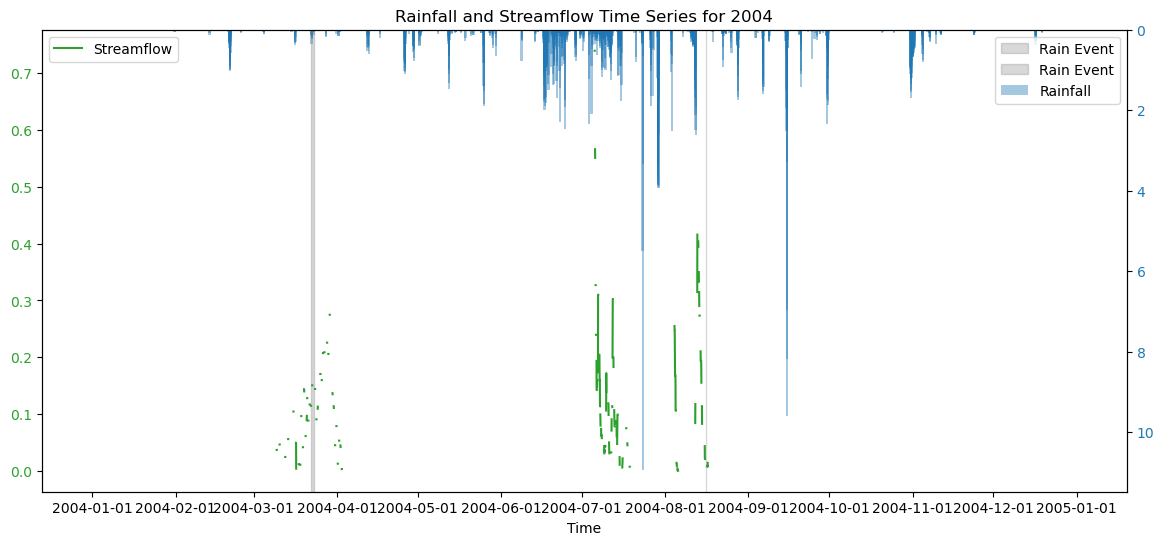

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

def plot_events_by_year(rain_csv_path, flow_csv_path, events_csv_path, output_folder):
    # 读取降雨数据
    rain_df = pd.read_csv(rain_csv_path)
    rain_df['time'] = pd.to_datetime(rain_df['time'])
    rain_df.set_index('time', inplace=True)

    # 读取流量数据
    flow_df = pd.read_csv(flow_csv_path)
    flow_df['time'] = pd.to_datetime(flow_df['time'])
    flow_df.set_index('time', inplace=True)

    # 读取事件数据
    events_df = pd.read_csv(events_csv_path)
    events_df['BEGINNING_RAIN'] = pd.to_datetime(events_df['BEGINNING_RAIN'])
    events_df['END_RAIN'] = pd.to_datetime(events_df['END_RAIN'])

    # 获取唯一的年份列表
    years = events_df['BEGINNING_RAIN'].dt.year.unique()

    # 为每个年份绘制图表
    for year in years:
        # 筛选当前年份的数据
        rain_df_year = rain_df[rain_df.index.year == year]
        flow_df_year = flow_df[flow_df.index.year == year]
        events_df_year = events_df[events_df['BEGINNING_RAIN'].dt.year == year]

        # 创建图形
        fig, ax1 = plt.subplots(figsize=(14, 6))

        # 绘制流量数据
        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.plot(flow_df_year.index, flow_df_year['streamflow'], label='Streamflow', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # 创建第二个轴来绘制降雨数据
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.bar(rain_df_year.index, rain_df_year['total_precipitation_hourly'], label='Rainfall', color=color, alpha=0.4)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.invert_yaxis()  # 降水量图表倒置显示

        # 标记事件
        for index, row in events_df_year.iterrows():
            beginning_rain = mdates.date2num(row['BEGINNING_RAIN'])
            end_rain = mdates.date2num(row['END_RAIN'])
            ax2.axvspan(beginning_rain, end_rain, color='gray', alpha=0.3, label='Rain Event')

        # 设置图例
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # 设置标题
        plt.title(f'Rainfall and Streamflow Time Series for {year}')

        # 保存图表到指定的文件夹
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        output_path = os.path.join(output_folder, f'{basin_id}_{year}.png')
        print(f'{basin_id}_{year}.png save in ', output_folder)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()

# 使用示例
if __name__ == "__main__":

    basin_id = 'neimenggu_20205510'
    rain_csv_path =  '/ftproot/basins-neimenggu/timeseries/1h/neimenggu_20205510.csv'   # 降雨数据文件路径
    flow_csv_path = '/ftproot/basins-neimenggu/timeseries/1h/neimenggu_20205510.csv'   # 流量数据文件路径
    events_csv_path = '/home/zlh/HydroNeimeng/picture/neimenggu_20205510_events.csv'  # 事件数据文件路径
    output_folder = f'./plt_{basin_id}' 

    plot_events_by_year(rain_csv_path, flow_csv_path, events_csv_path, output_folder)


绘制时序图，按照场次

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
plt.rcParams['font.family']='SimHei'

def plot_event(rain_df, flow_df, event, output_folder, event_index,basin_area):
    # 创建图形和轴
    fig, ax1 = plt.subplots(figsize=(18, 6))

    # 单位转换
    flow =  flow_df['streamflow']*3.6/basin_area

    ax1.plot(flow_df.index, flow, label='径流值', color='green')
    ax1.set_ylabel('径流值 (m^3/s)', color='green')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # 每12小时显示一个刻度
    ax1.tick_params(axis='y', labelcolor='green')

    # 创建第二个轴来绘制降雨数据
    ax2 = ax1.twinx()
    ax2.bar(rain_df.index, rain_df['total_precipitation_hourly'], width=0.01,label='降雨量', color='blue', alpha=0.6) # width宽度
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylabel('降雨值 (mm)', color='blue')
    ax2.invert_yaxis()  # 降水量图表倒置显示

    # 标记事件
    beginning_rain = mdates.date2num(event['BEGINNING_RAIN'])
    end_rain = mdates.date2num(event['END_RAIN'])
    ax1.axvspan(beginning_rain, end_rain, color='gray', alpha=0.3, label='Rain Event')

    # 设置图例
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 设置标题
    plt.title(f'Event {event_index + 1}')

    # 保存图表到指定的文件夹
    output_path = os.path.join(output_folder, f'event_{event_index + 1}.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

    print(f"Plot for event {event_index + 1} saved to {output_path}")

def plot_events_by_event(rain_csv_path, flow_csv_path, events_csv_path, output_folder,basin_area):
    # 读取降雨数据
    rain_df = pd.read_csv(rain_csv_path)
    rain_df['time'] = pd.to_datetime(rain_df['time'])
    rain_df.set_index('time', inplace=True)

    # 读取流量数据
    flow_df = pd.read_csv(flow_csv_path)
    flow_df['time'] = pd.to_datetime(flow_df['time'])
    flow_df.set_index('time', inplace=True)

    # 读取事件数据
    events_df = pd.read_csv(events_csv_path)
    events_df['BEGINNING_RAIN'] = pd.to_datetime(events_df['BEGINNING_RAIN'])
    events_df['END_RAIN'] = pd.to_datetime(events_df['END_RAIN'])

    # 为每个事件绘制图表
    for index, event in events_df.iterrows():
        # 筛选当前事件的数据
        mask = (rain_df.index >= event['BEGINNING_RAIN']) & (rain_df.index <= event['END_RAIN'])
        rain_df_event = rain_df.loc[mask]
        mask = (flow_df.index >= event['BEGINNING_RAIN']) & (flow_df.index <= event['END_RAIN'])
        flow_df_event = flow_df.loc[mask]

        # 绘制当前事件的图表
        plot_event(rain_df_event, flow_df_event, event, output_folder, index,basin_area)

# 使用示例
if __name__ == "__main__":
    basin_id = 'neimenggu_20205510'
    basin_area = 2341.733645
    rain_csv_path =  '/ftproot/basins-neimenggu/timeseries/1h/neimenggu_20205510.csv'   # 降雨数据文件路径
    flow_csv_path = '/ftproot/basins-neimenggu/timeseries/1h/neimenggu_20205510.csv'   # 流量数据文件路径
    events_csv_path = '/home/zlh/HydroNeimeng/picture/neimenggu_20205510_events.csv'  # 事件数据文件路径
    output_folder = f'./plt_{basin_id}' 
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    plot_events_by_event(rain_csv_path, flow_csv_path, events_csv_path, output_folder,basin_area)

/tmp/ipykernel_2702224/1451482347.py:41: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig(output_path, bbox_inches='tight')


Plot for event 1 saved to ./plt_neimenggu_20205510/event_1.png
Plot for event 2 saved to ./plt_neimenggu_20205510/event_2.png
Plot for event 3 saved to ./plt_neimenggu_20205510/event_3.png
Plot for event 4 saved to ./plt_neimenggu_20205510/event_4.png
Plot for event 5 saved to ./plt_neimenggu_20205510/event_5.png
Plot for event 6 saved to ./plt_neimenggu_20205510/event_6.png
Plot for event 7 saved to ./plt_neimenggu_20205510/event_7.png
Plot for event 8 saved to ./plt_neimenggu_20205510/event_8.png
Plot for event 9 saved to ./plt_neimenggu_20205510/event_9.png
Plot for event 10 saved to ./plt_neimenggu_20205510/event_10.png
Plot for event 11 saved to ./plt_neimenggu_20205510/event_11.png
Plot for event 12 saved to ./plt_neimenggu_20205510/event_12.png
Plot for event 13 saved to ./plt_neimenggu_20205510/event_13.png
Plot for event 14 saved to ./plt_neimenggu_20205510/event_14.png
Plot for event 15 saved to ./plt_neimenggu_20205510/event_15.png
Plot for event 16 saved to ./plt_neimenggu_